<center>
    <h1>Metody analizy i wizualizacji dużych zbiorów danych</h1>
    <h2>Laboratorium 1 - PCA</h2>
    <h4>Jan Gołda, Wojciech Basiura, WIET 2018/2019</h4>
</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
def perform_pca(data, components_number=None, scale=False):
    """ Performs PCA od given data """
    
    # scale data if requested
    if scale:
        data = StandardScaler().fit_transform(data)

    # perform PCA
    pca = PCA(n_components=components_number)
    components = pca.fit_transform(data)
    
    return pca, pd.DataFrame(data=components)

def perform_kernel_pca(data, components_number=None, scale=False, gamma=None):
    """ Performs kernel-PCA on given data """
    
    # scale data if requested
    if scale:
        data = StandardScaler().fit_transform(data)

    # perform kPCA
    kpca = KernelPCA(kernel="rbf", n_components=components_number, gamma=gamma)
    components = kpca.fit_transform(data)
    
    return kpca, pd.DataFrame(data=components)

def perform_knn(data, labels, k):
    """ Calculates the percentage of neighbours that belong to the same class for each sample in data """
    
    knn = NearestNeighbors(k, algorithm='brute').fit(data)
    distances, indices = knn.kneighbors(data)
    
    return [
        sum(1 for n in neighbours if labels[n] == labels[i]) / k
        for i, neighbours in enumerate(indices)
    ]

def plot_pca_2d(components, **kwargs):
    """ Plots first two pca components """
    plt.scatter(components[0], components[1], **kwargs)
    plt.xlabel("1st component")
    plt.ylabel("2nd component")  
    plt.show()

def plot_pca_3d(components, **kwargs):
    """ Plots first three pca components """
    ax = plt.axes(projection='3d')
    ax.scatter3D(components[0], components[1], components[2], **kwargs);
    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')
    ax.set_zlabel('3rd component')
    plt.show()

def plot_histogram(values, components_number=None):
    """ Plots histogram described in procentages """
    
    # calculate procentages
    total = sum(values)
    y = [v * 100 / total for v in values[:components_number]]
    x = range(len(y))
    labels = ['PC ' + str(i+1) for i in x]
    
    # plot
    plt.bar(x, y, tick_label=labels)
    plt.xticks(rotation=90)
    plt.ylabel("[%]")
    plt.show()

def plot_knn_metrics(data, labels, k_values):
    """ Plots graph representing procentage of neighbours from the sae class for different values of k"""
    
    # generating metrics for each k
    y = [np.mean(perform_knn(data, labels, k)) * 100 for k in k_values]
    
    # plot
    plt.plot(k_values, y, '-')
    plt.xlabel("k")
    plt.ylabel("[%]")
    plt.show()

def plot_images(x, y, images, zoom=1):
    # get axis
    ax = plt.gca()
    
    # create offseted images
    offseted_images = [OffsetImage(img, cmap='gray', zoom=zoom) for img in images]
    
    # plot images
    for x0, y0, img in zip(x, y, offseted_images):
        ax.add_artist(AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    plt.plot()

---
## Zbiór danych: Breast cancer
Źródło zbioru: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)  
Opis zbioru: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names  

Zbiór ten składa się z pojedyńczych wystąpień raka piersi, zbadanych i opisanych przy pomocy poniższych atrybutuów.  
Wyniki podzielone są na dwie klasy: raka łagodnego i złośliwego.  
Naszym celem będzie zwizualizowanie tych dwóch klas przy pomocy PCA.

#### Atrybuty elementów zbioru
1. **Sample code number**: int  
2. **Clump thickness**: int [1, 10]  
3. **Uniformity of Cell Size**: int [1, 10]  
4. **Uniformity of Cell Shape**: int [1, 10]  
5. **Marginal Adhesion**: int [1, 10]  
6. **Single Epithelial Cell Size**: int [1, 10]  
7. **Bare Nuclei**: int [1, 10]  
8. **Bland Chromatin**: int [1, 10]  
9. **Normal Nucleoli**: int [1, 10]  
10. **Mitoses**: int [1, 10]  
11. **Class**: 2 for benign, 4 for malignant  

#### Przykład danych

In [3]:
names = ['Thickness', 'UO cell size', 'UO cell shape', 'Adhesion', 'SE cell size',
         'Nuclei', 'Chromatin', 'Nucleoli', 'Mitoses', 'Class']
df = pd.read_csv('data/breast-cancer-wisconsin.data', names=names, delimiter=',')

In [4]:
df.head()

,Thickness,UO cell size,UO cell shape,Adhesion,SE cell size,Nuclei,Chromatin,Nucleoli,Mitoses,Class
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


#### Czyszczenie oraz przygotowywanie danych
Zanim zabierzemy się za wykonanie PCA musimy oczyścić i przygotować dane.  
W przypadku tych danych problemy pojawiają się z kolumnie 'Nuclei' dla której brakuje danych w kilku wierszach. Dane te zastąpione są przez '?' co powoduje problemy przy dalszych obliczeniach. Jako że tych wierszy jest nie znaczna ilość poprostu usuniemy problematyczne wiersze.  
Dodatkowo musimy odseparować dane od przypisanych im klas, jako że wpływało by to na wyniki PCA, znacznie zawyżając ich precyzje.

In [5]:
# in some rows Nuclei is not provided, so we just remove these rows
df_filtered = df.loc[df['Nuclei'] != '?'].astype(int)

# separate data from labels
df_data = df_filtered.iloc[:, :9]
df_labels = df_filtered.iloc[:, 9]

# prepare colors list for plotting
colors = ['green' if l == 2 else 'red' for l in df_labels]

#### Wykonanie PCA
Wykonumemy PCA (Principal Component Analysis) otrzymując następujące wyniki:

In [6]:
pca, df_pca = perform_pca(df_data, scale=True)

In [7]:
df_pca.head()

,0,1,2,3,4,5,6,7,8
0,-1.470171,-0.104273,-0.565685,-0.031959,-0.150998,0.060021,0.349403,0.420344,-0.005691
1,1.442046,-0.570141,0.236601,-0.478150,1.643085,-0.483035,-1.115899,0.379577,0.023427
2,-1.592478,-0.076120,0.048858,-0.092388,-0.059739,-0.279371,0.232740,0.209800,0.013372
3,1.479812,-0.528452,-0.603048,1.410827,-0.560737,0.063028,-0.211115,-1.607095,0.182777
4,-1.344862,-0.090719,0.029997,-0.338284,-0.108829,0.431370,0.259862,0.446655,-0.038820


Które po przedstawieniu na wykresach dwu i trzy wymiarowych wyglądają następująco:  
(wykresy tworzone są przyjęcie x = PC1, y = PC2, z = PC3)

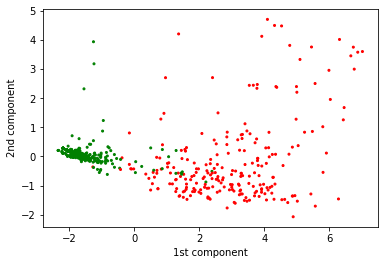

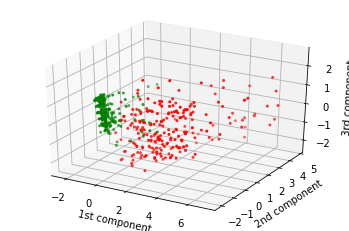

In [8]:
plot_pca_2d(df_pca, c=colors, s=4)
plot_pca_3d(df_pca, c=colors, s=4)

Jak widać PCA poprawnie oddzieliło od siebie klasy, tworząc z nich klastry. Co prawda nie jest to idealny podział, ale zważywszy że operujemy na prawdziwych danych medycznych nie jest to nic dziwnego.

#### Historgam PCA
Poniższy wykres przedstawia wariancję poszczególnych atrybutów PCA w stosunku do całości.  
Jak widać około 65% informacji zawartych jest w PC1, a zatem nawet rzutowanie tych danych na prostą dało by wyraźnie podzielone wyniki. Jest to wyraźnie widoczne również na wykresach powyżej.

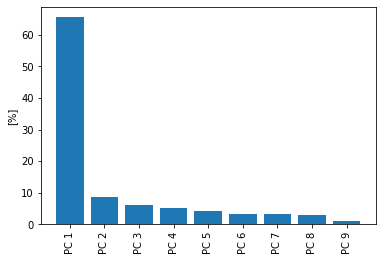

In [9]:
plot_histogram(pca.explained_variance_)

#### Metryka KNN na podstawie PCA
Poniższy wykres przedstawia jaki procent z posód k najbliższych sąsiadów należy do tej samej klasy (wyniki uśrednione dla całego zbioru).  
Jak widać dla 3 najbliższych sąsiadów ponad 97% należy do tej samej klasy, natomiast wraz ze wzrostem ilości sąsiadów, a zatem również ich odległości od siebie ten procent maleje.

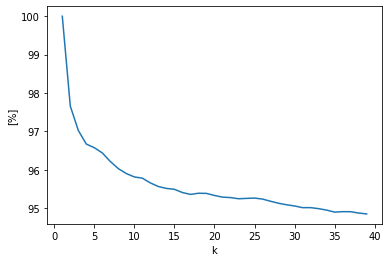

In [10]:
plot_knn_metrics(df_pca, df_labels.tolist(), range(1,40))

#### Wykonanie kernel-PCA
Dla porównania wykonamy również kPCA (Kernel Principal Component Analysis) otrzymując następujące wyniki:

In [11]:
kpca, df_kpca = perform_kernel_pca(df_data, scale=True, gamma=0.1)

In [12]:
df_kpca.head()

,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
0,-0.324718,0.249414,-0.151469,-0.048837,0.003813,0.124990,0.106435,-0.075993,-0.019579,-0.050320,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00
1,0.519088,0.200045,0.314022,0.254557,0.108929,-0.028508,0.034029,0.372634,-0.095099,-0.179584,...,1.088349e-13,-4.462515e-13,1.638296e-13,-8.173334e-14,-1.932257e-14,7.238061e-13,-6.127493e-14,6.636088e-13,9.611809e-13,1.676967e-13
2,-0.379758,0.030497,0.046765,-0.025481,-0.023856,0.117717,0.083105,-0.061674,-0.023849,-0.028891,...,1.088339e-13,-4.462505e-13,1.638326e-13,-8.173440e-14,-1.932594e-14,7.238044e-13,-6.127311e-14,6.636094e-13,9.611765e-13,1.676964e-13
3,0.520218,0.176299,0.086001,-0.197612,-0.361906,-0.176979,-0.082350,0.141241,0.032429,0.352320,...,1.088349e-13,-4.462515e-13,1.638296e-13,-8.173334e-14,-1.932257e-14,7.238061e-13,-6.127493e-14,6.636088e-13,9.611809e-13,1.676967e-13
4,-0.321655,0.160328,-0.049395,-0.027024,0.050743,0.145766,0.053224,-0.010215,0.095392,-0.014762,...,-9.965684e-11,-3.056999e-11,9.939067e-11,4.241459e-11,-4.709597e-11,6.281569e-11,-2.389918e-11,7.109433e-11,4.326479e-11,3.599432e-11


I podobnie jak w przykadu PCA przedstawimy je na wykresach:

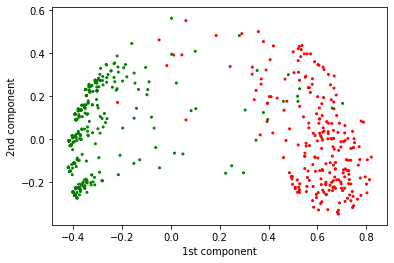

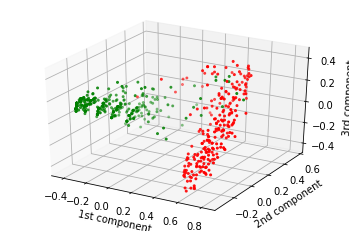

In [13]:
plot_pca_2d(df_kpca, c=colors, s=4)
plot_pca_3d(df_kpca, c=colors, s=4)

Porównując te wykresy z wykresów PCA widać, że kernel-PCA lepiej odseparował od klasy (chociaż dalej nie idealnie, ale o tym była mowa wcześniej) 

#### Histogram kernel-PCA
Histogram kernel-PCA na pierwszy rzut oka wygląda tak samo jak histogram PCA, a zatem PC1 ma zdecydowanie większe znaczenie niż pozostałe.  
Zauważmy jednak że udział procentowy zdecydowanie spadł (tutaj ok. 37% w porównaniu do ok. 65%). Wynika to z tego że PCA wygenerowało 9 wymiarów podczas gdy wynik k-PCA ma ponad 570 (na histogramie pokazane tylko 20 najważniejszych).

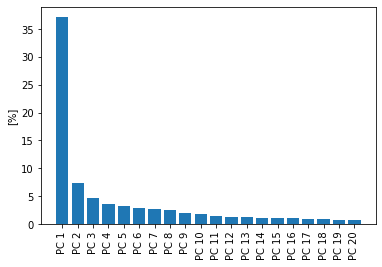

In [14]:
plot_histogram(kpca.lambdas_, components_number=20)

#### Metryka KNN na podstawie kernel-PCA

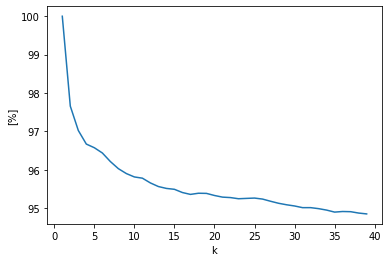

In [15]:
plot_knn_metrics(df_kpca, df_labels.tolist(), range(1,40))

Porównanie wykresu tej metryki z wykresem dla PCA, pokazuje że pod tym względem obie metody są bardzo zbliżone.

#### Porównanie dla 5 najbliższych sąsiadów
Poniżej znajdują się wyniki obliczenia matryki KNN dla 5 najbliższych sąsiadów, dla: oryginalnych danych, wyniku PCA oraz wyniku kernel-PCA.

In [16]:
mean_data = np.mean(perform_knn(df_data, df_labels.tolist(), 5))
mean_pca = np.mean(perform_knn(df_pca, df_labels.tolist(), 5))
mean_kpca = np.mean(perform_knn(df_kpca, df_labels.tolist(), 5))

In [17]:
print("data:\t", mean_data)
print("PCA:\t", mean_pca)
print("kPCA:\t", mean_kpca)

data:	 0.9674963396778917
PCA:	 0.9657393850658859
kPCA:	 0.9657393850658859


Jak widać PCA jak i kernel-PCA osiągneły porównywalny wynik, tylko nieznacznie gorszy od wyniku dla nie przetworzonych danych.  
Świadczy to o tym, że metody ten żeczywiście redukują ilość wymiarów tracąc przy tym tylko nieznaczną część informacji.

---
## Zbiór danych: MNIST Digits
Źródło zbioru: https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer/data?fbclid=IwAR33vMD-lH2mIFOBBIM4bDdjtQ52xmnYLTDTqZQtaKUjHVrnrQP9jrzWXWI

Zbiór ten składa się z czarno-białych obrazków rozmiaru 28x28 przedstawiających ręcznie napisane cyfry, skategoryzowanych wg przedstawianej cyfry.  
Pobrany zbiór ma znaczny rozmiar, nie możliwy do ładnego graficznego zaprezentowania, w związku z tym ograniczamy go do 5000 losowo wybranych obrazków.

#### Przykład danych

In [18]:
# restrict data to random 5000
df = pd.read_csv('data/mnist-digits.data', delimiter=',').sample(5000)

In [19]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
14263,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4852,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20140,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28917,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11667,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


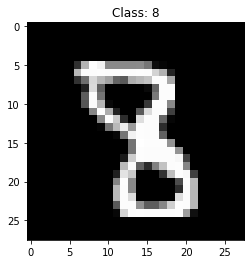

In [20]:
plt.imshow(df.iloc[0, 1:].values.reshape(28, 28), cmap='gray')
plt.title(f'Class: {df.iloc[0, 0]}')
plt.show()

#### Przygotowanie danych
Podobnie jak w przypadku poprzedniego zbioru danych odseparowywujemy dane od przypisanych im klas.

In [21]:
COLORS = ['m', 'k', 'w', 'g', 'c', 'y', 'r', 'b', 'pink', 'orange']

# separate data from labels
df_data = df.iloc[:, 1:]
images = df_data.values.reshape(-1, 28, 28)
labels = df.iloc[:, 0]
colors = [COLORS[i] for i in labels]

#### Wykonanie PCA
Po wykonaniu PCA otrzymujemy następujące wyniki:

In [22]:
pca, df_pca = perform_pca(df_data, scale=True)

In [23]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-2.274619,10.158350,6.613469,5.217687,0.376046,4.375372,1.420452,-1.762474,-3.763862,1.671535,...,0.0,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
1,-4.291140,-8.385220,1.914525,-6.635563,-4.139010,4.695071,3.727485,2.365408,-13.547856,-4.824109,...,0.0,-3.513643e-17,4.840687e-18,1.545609e-17,1.595150e-17,4.496777e-17,-1.386122e-17,-9.710866e-18,1.260627e-17,3.252447e-19
2,-6.244714,2.566352,-4.939198,0.030994,-3.660476,-3.086877,-2.194448,-1.690229,0.263242,0.525047,...,0.0,-3.209344e-15,-2.567704e-15,-8.645418e-16,-6.281687e-16,9.792552e-16,-1.375259e-15,3.807619e-16,1.280372e-16,2.866605e-16
3,-6.446156,1.151257,-2.553763,-2.271719,-0.111817,-2.801683,2.721619,-1.858151,0.486263,2.391460,...,0.0,-1.758896e-15,-8.942063e-17,-2.535889e-17,5.016490e-16,1.555804e-15,1.139650e-15,-3.634107e-16,1.855518e-16,-1.074500e-17
4,-0.108627,-0.264208,2.482265,-3.729218,-8.306794,-4.900458,-0.512135,1.845894,0.238020,-0.452512,...,0.0,8.310064e-16,-2.125902e-16,-3.629840e-16,5.854064e-16,-7.813021e-16,1.466125e-16,3.128963e-16,-2.042461e-16,-1.731772e-16


Które zwizualizowane w przestrzeni 2D oraz 3D przedstawiają się następująco:

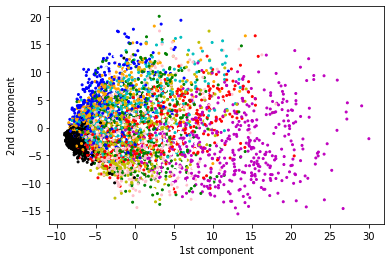

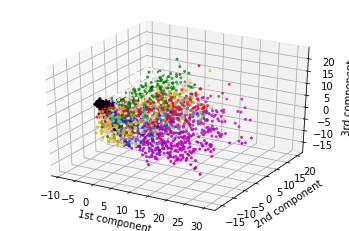

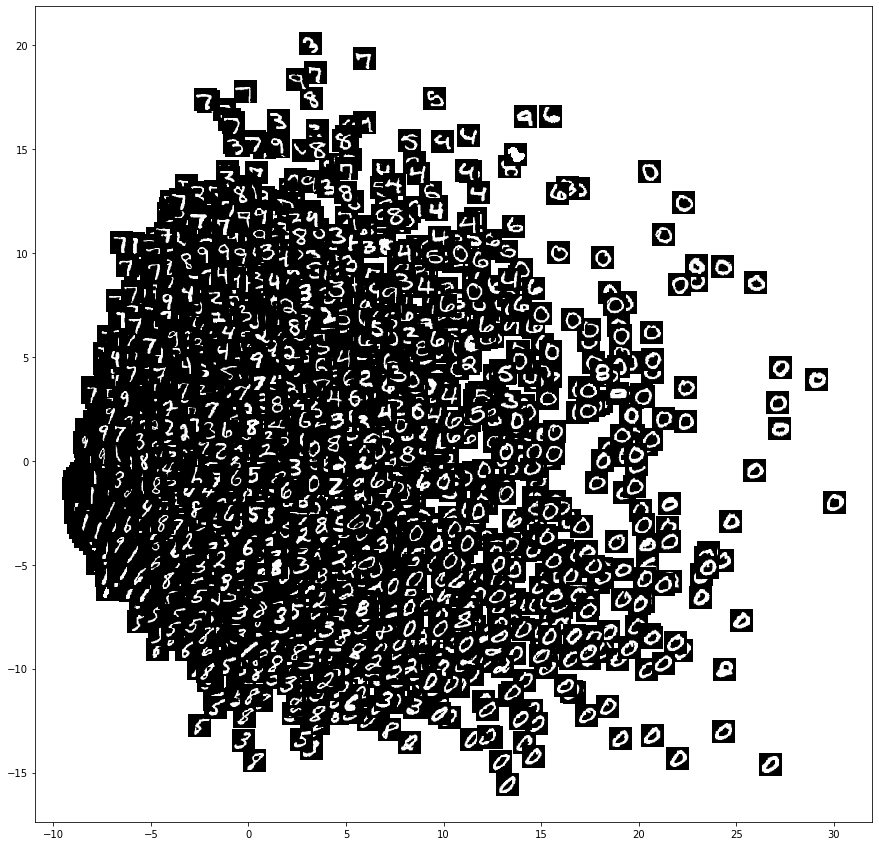

In [24]:
plot_pca_2d(df_pca, c=colors, s=4)
plot_pca_3d(df_pca, c=colors, s=4)
plt.figure(figsize=(15, 15))
plot_images(df_pca[0], df_pca[1], images, zoom=0.8)

Jak możemy zauważyć część obrazków została częściowo odseparowana od reszty (zero/fiolet, siedem/niebieski, jeden/czerń) lecz zdecydowana ich większość jest całkowicie pomieszana.

#### Histogram PCA
To co zaobserwowaliśmy powyżej potwierdza histogram:

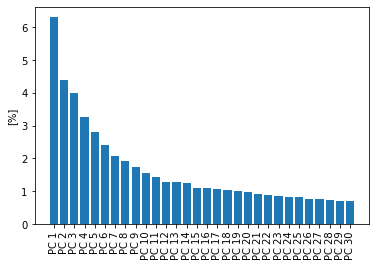

In [25]:
plot_histogram(pca.explained_variance_, components_number=30)

PC1 (x) i PC2 (y) stanowią sumarycznie ledwo ponad 10% całości, a zatem nic dziwnego że ciężko jest odseparować wizualnie dane.

#### Wykonanie kernel-PCA
Wyniki dla kernel-PCA ograniczyliśmy do 20 componentów z racji na czas potrzebny na obliczenia

In [26]:
kpca, df_kpca = perform_kernel_pca(df_data, components_number=20, scale=True)

In [27]:
df_kpca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.113983,-0.038024,-0.093388,0.244863,-0.124576,-0.058019,0.009517,0.042324,0.018031,0.056298,-0.056660,0.082673,0.091520,-0.014036,-0.125508,-0.062978,-0.068072,-0.039289,0.016675,-0.087148
1,0.446358,-0.145050,-0.186369,0.035714,-0.027616,-0.034164,-0.093092,-0.044989,-0.003836,0.004232,-0.023303,-0.056998,-0.043604,0.010969,0.055130,-0.053362,0.055000,-0.067290,0.007688,-0.019396
2,-0.233339,0.305987,-0.151324,0.005134,0.006429,0.019572,-0.116331,-0.076285,0.088176,-0.112773,0.099752,-0.191691,0.051520,0.110890,-0.034875,-0.081964,-0.060652,-0.015746,-0.064424,0.015692
3,-0.282808,0.142957,-0.104419,0.020539,0.128595,0.013819,0.003942,-0.170196,-0.038800,-0.027788,-0.029521,-0.071674,-0.061044,-0.025583,-0.098406,-0.003630,-0.076444,-0.140654,-0.064338,-0.012658
4,-0.062948,0.125561,0.198202,0.051614,0.197249,-0.152186,-0.177336,0.068511,0.027987,0.016127,-0.018158,-0.141727,0.037283,-0.106568,0.100655,0.010441,0.038382,0.131728,-0.010669,0.082403


Zwizualizowane wyniki prezentują się następująco:

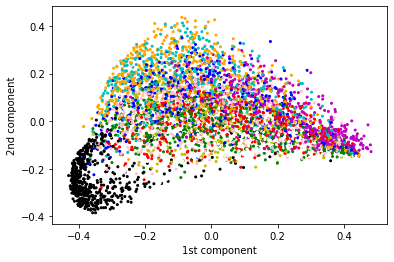

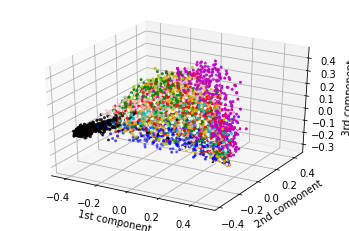

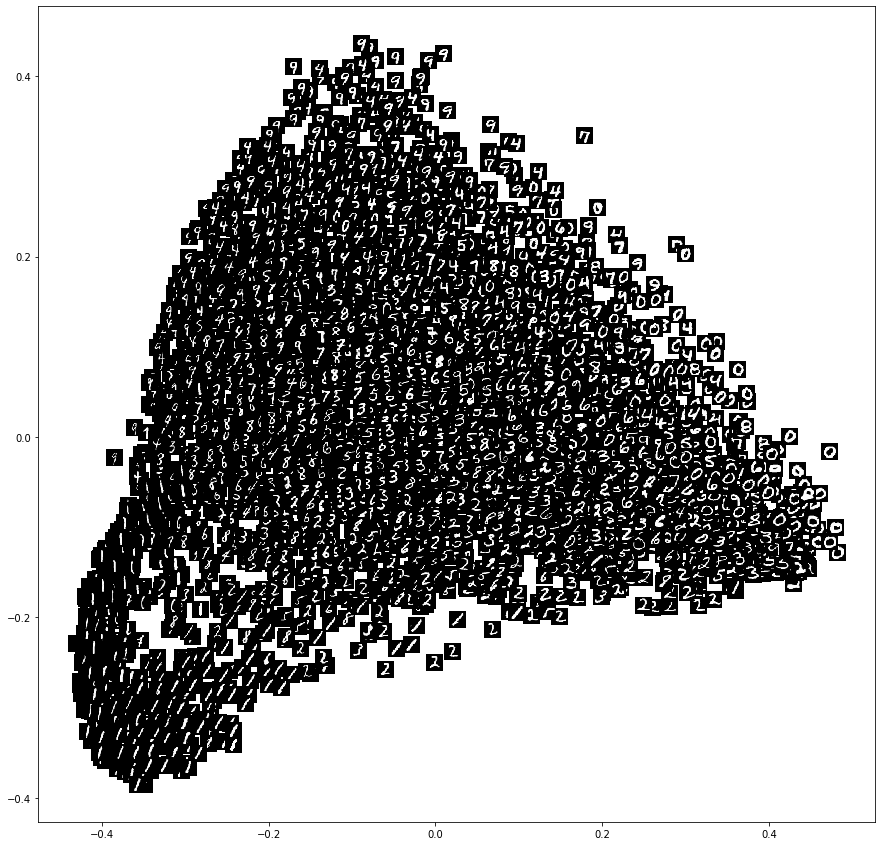

In [28]:
plot_pca_2d(df_kpca, c=colors, s=4)
plot_pca_3d(df_kpca, c=colors, s=4)
plt.figure(figsize=(15, 15))
plot_images(df_kpca[0], df_kpca[1], images, zoom=0.6)

Podopnie jak w przypadku PCA, cyfry są mocno pomieszane ale można zauważyć pewne grupy (np. jeden/czerń czy zero/fiolet).  
Warto zauważyć że wydzielenie zer/fioletu w 2D jest prawie nie możliwe, tymczasem w 3D są one dosyć odseparowane.

#### Histogram kernel-PCA

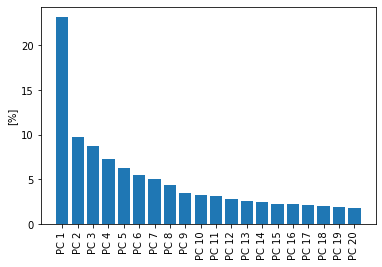

In [29]:
plot_histogram(kpca.lambdas_)

Patrząc na histogram może się wydawać że jest trochę lepiej niż dla PCA, ponieważ PC1 i PC2 sumują się do prawie 24%. Nie jest to niestaty do końca prawda, ponieważ trzeba wziąść pod uwagę że ograniczyliśmy ilość komponentów, a zatem spadła wartość odpowiadająca 100%.

---
## Wnioski
Przeprowadzone testy, wykonane na dwóch zbiorach: łatwiejszym i trudniejszym, pokazują że o ile metoda PCA dobrze się sprawdza przy redukcji względnie prostych zbiorów (breast cancer) do mniejszej liczby wymiarów, o tyle dla zbiorów trudnieszych (digits) wykonywana redukcja nie jest wystarczająca, nie pozwala sprowadzić danych do kilku wymiarów.